# Likelihood-free Inference

_Alex Malz (LINCC@CMU)_
_LSSTC Data Science Fellowship Program #16_

In [2]:
#!pip install --quiet jax-cosmo numpyro dm-haiku optax sbi chainconsumer tensorflow-probability numpyro lenstools pzflow

^C
ERROR: Operation cancelled by user


In [3]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions

import haiku as hk
seq = hk.PRNGSequence(42)

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

from chainconsumer import ChainConsumer

import lenstools as lt
import astropy.units as u

import pzflow

/home/soumyodiptak/anaconda3/envs/dsfp/lib/python3.8/site-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


In [ ]:
# sadly there's a bug due to a deprecated jax function so we can't do the cool thing using this )-;
# !pip install --quiet git+https://github.com/EiffL/powerbox-jax.git
# import powerbox_jax as pbj

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Theory

When explicit likelihoods are unavailable, we can't do MCMC sampling, so we need alternatives.
Those that use an _implicit_ likelihood, in the form of any process that takes in the parameters we want to constrain and outputs realizations of data, form a family of closely related methods called Likelihood-free Inference (LFI), which may also be referred to as Simulation-based Inference (SBI) and which includes Approximate Bayesian Computation (ABC).

![overview](01_algorithms_tikz.png "terminology")

This diagram from [Lueckmann+ 2021](https://arxiv.org/abs/2101.04653), via [Lanusse 2022](https://eiffl.github.io/talks/EAS2022/), illustrates the nuances between terminology for these methods, which seem to change every few years, but the principle behind them is the same.
Instead of evaluating the likelihood of proposed parameters, a black-box implicit likelihood, typically a simulator or emulator, is used to forward-model mock data that is then compared with the real data.
In both approaches, sampled parameters that are accepted are used to generate subsequent samples. 

## Astrophysical context

Let's try to learn the cosmological parameters from summary statistics of weak lensing mass maps, with and without using the likelihood.
This problem is distilled from [a tutorial](https://colab.research.google.com/drive/1K8cB1h3ge3kTVut81Xnkw2kNiKFIn8HI?usp=sharing) by Francois Lanusse;
all errors are mine.

Let's start by forward modeling weak lensing mass maps.
(This uses a lot of `jax` magic I'm not an expert in, so it's a bit of a black box to me, but that's also why it's fast enough to run in a problem session.)

In [ ]:
## LensingForwardModelLogNormal

Our summary statistic will be the weak lensing power spectrum, which is basically an angular correlation function in Fourier space.
(A surprisingly good introduction to the power spectrum can be found [here](https://www.astro.caltech.edu/~george/ay21/eaa/eaa-powspec.pdf).)
Our physical model will try to generate weak lensing mass maps whose power spectra are close to that of our "observations".
The guts of the physical model are `make_power_map()` and `make_lognormal_power_map`, which generate the mass map itself and then (optionally) convolve it with a lognormal lensing kernel.

In [6]:
def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
    k = 2*jnp.pi*jnp.fft.fftfreq(N, d=field_size / N)
    kcoords = jnp.meshgrid(k,k)
    k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0,0].set(zero_freq_val)
    return ps_map * (N / field_size)**2

def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):
    power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
    power_spectrum_for_lognorm = jnp.log(1 + power_spectrum_for_lognorm/shift**2)
    power_spectrum_for_lognorm = jnp.abs(jnp.fft.fft2(power_spectrum_for_lognorm))
    power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0,0].set(0.)
    return power_spectrum_for_lognorm

### The 

The simulation model makes mass maps from the cosmological parameters.
The priors on the cosmological parameters ($\Omega_{c}$ and $\sigma_{8}$ here) enter here, and you can try making more versions of the model function to try different priors.
There's also a latent variable, which can represent something like initial conditions, or you can imagine it as being where in the sky you're looking (maybe).

The simulation model has some free parameters that affect the time it will take to run as well as how interesting it is.
Higer `N` will expand the dimensionality of the data.
Make sure `map_size` and `gal_per_arcmin2` don't conspire to give you no galaxies in your map.

In [62]:
def model(N=128,               # number of pixels on the map
          map_size=10,         # map size in deg.
          gal_per_arcmin2=100,   
          sigma_e=0.2, 
          shift=0.05,
          model_type='lognormal'): # either 'lognormal' or 'gaussian'      
    
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * jnp.pi    # radians

    # Sampling cosmology
    omega_c = numpyro.sample('omega_c', dist.Normal(0., 1.0)) * 0.05 + 0.3
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0., 1.0)) * 0.05 + 0.8
    
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    
    # Defining the function that will compute the power spectrum of the field
    # Create an interpolation array for the cls to avoid far too many computations
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
    
    # Sampling latent variables
    z = numpyro.sample('z', dist.MultivariateNormal(loc=jnp.zeros((N,N)), precision_matrix=jnp.eye(N)))

    # Convolving by the power spectrum
    power_map = make_power_map(P, N, map_size) 
    if model_type == 'lognormal':
        power_map =  make_lognormal_power_map(power_map, shift)

    field = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real

    if model_type == 'lognormal':
        field = shift * (jnp.exp(field - jnp.var(field) / 2) - 1)

    # Adding "observational noise"
    x = numpyro.sample('x', dist.Independent(dist.Normal(field, sigma_e/jnp.sqrt(gal_per_arcmin2 * pix_area)), 2))
    
    return x

Now we can generate weak lensing mass maps for arbitrary values of the cosmological parameters.

In [63]:
# Create our fiducial observations
fiducial_model = condition(model, {'omega_c': 0., 'sigma_8': 0.})
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(42))
m_data = sample_map_fiducial()

/home/soumyodiptak/anaconda3/envs/dsfp/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/home/soumyodiptak/anaconda3/envs/dsfp/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/home/soumyodiptak/anaconda3

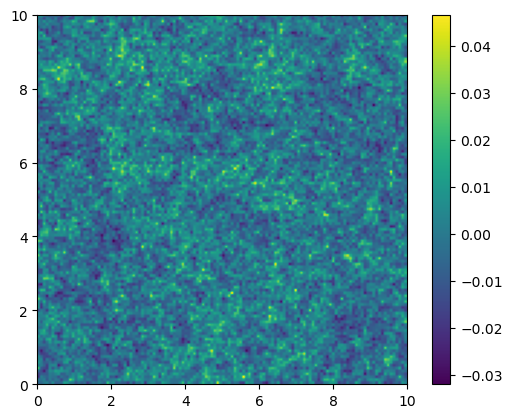

In [64]:
plt.imshow(m_data, extent=(0,10,0,10))
plt.colorbar()

We can look at multiple draws with the same cosmological parameters to see how the latent variables affect the maps.

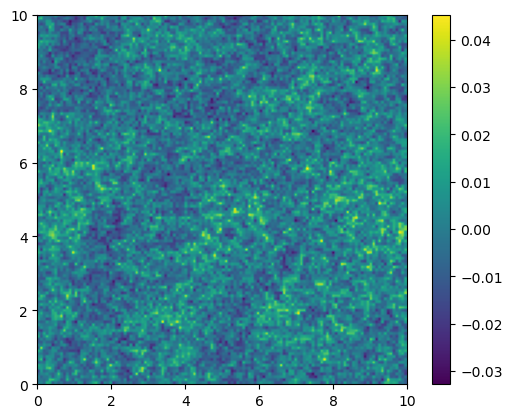

In [65]:
other_m_data = sample_map_fiducial()
plt.imshow(other_m_data, extent=(0,10,0,10))
plt.colorbar()

### The summary statistic

We'll use the power spectrum as a summary statistic.

In [66]:
kmap_lt = lt.ConvergenceMap(m_data, 10*u.deg)
l_edges = np.arange(100.0,3000.0,100.0)
l2,Pl2 = kmap_lt.powerSpectrum(l_edges)

Let's compare against the power spectrum predicted by the cosmological parameters from Planck.

In [67]:
# Checking that the power spectrum looks ok with Lenstools
cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8)
# Creating a given redshift distribution
pz = jc.redshift.smail_nz(0.5, 2., 1.0)
tracer = jc.probes.WeakLensing([pz])

Unsurprisingly, our guess of $\Omega_{c}=0, \sigma_{8}=0$ wasn't very good!
(Check out Tuesday's `metrics.ipynb` notebook for more on $\sigma_{8}$.)

Text(0, 0.5, 'power spectrum $C_{\\ell}$')

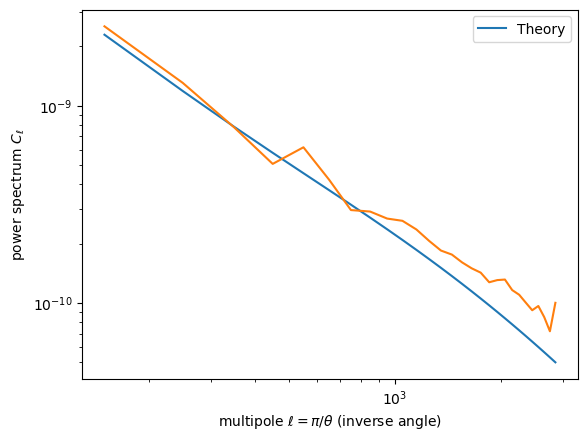

In [68]:
cell = jc.angular_cl.angular_cl(cosmo, l2, [tracer])[0]
plt.plot(l2, cell, label='Theory')
plt.plot(l2, Pl2)
plt.loglog()
plt.legend()
plt.xlabel(r'multipole $\ell=\pi/\theta$ (inverse angle)')
plt.ylabel(r'power spectrum $C_{\ell}$')

## Part 1: MCMC sampling

We _could_ MCMC sample this just to have something to check against the LFI results.
_(The following does MCMC sampling with `numpyro`, with which I'm not super familiar, so you'll have to consult the documentation if you have any questions about the mechanics, sorry!)_

In [69]:
# Now we condition the model on obervations
observed_model = condition(model, {'x': m_data})

In [70]:
nuts_kernel = numpyro.infer.NUTS(observed_model,
                                 init_strategy=numpyro.infer.init_to_median,
                                 max_tree_depth=6,
                                 step_size=0.02)

In [71]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=100, 
                          num_samples=1000)

This step is very slow, so I did it for you.
Download the file from [the data directory here](https://github.com/aimalz/dsfp2022) and change the path below as needed.

In [72]:
# # very slow on CPU (>1 hour), might be faster on GPU (<1 hour)
# mcmc.run(jax.random.PRNGKey(3))

# res = mcmc.get_samples()

# # Saving the trace
# with open('lensing_fwd_mdl_lognorm.pickle', 'wb') as handle:
#     pickle.dump(res, handle)#, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('lensing_fwd_mdl_lognorm.pickle', 'rb') as handle:
    res = pickle.load(handle)#, protocol=pickle.HIGHEST_PROTOCOL)

Let's check out the samples!
(The color indicates their order in the chain.
If I'd waited for actual convergence and thrown out the burn-in, there'd be no pattern, but you can see that later samples are more tightly clustered because I was impatient.)

Text(0, 0.5, '$\\sigma_8$')

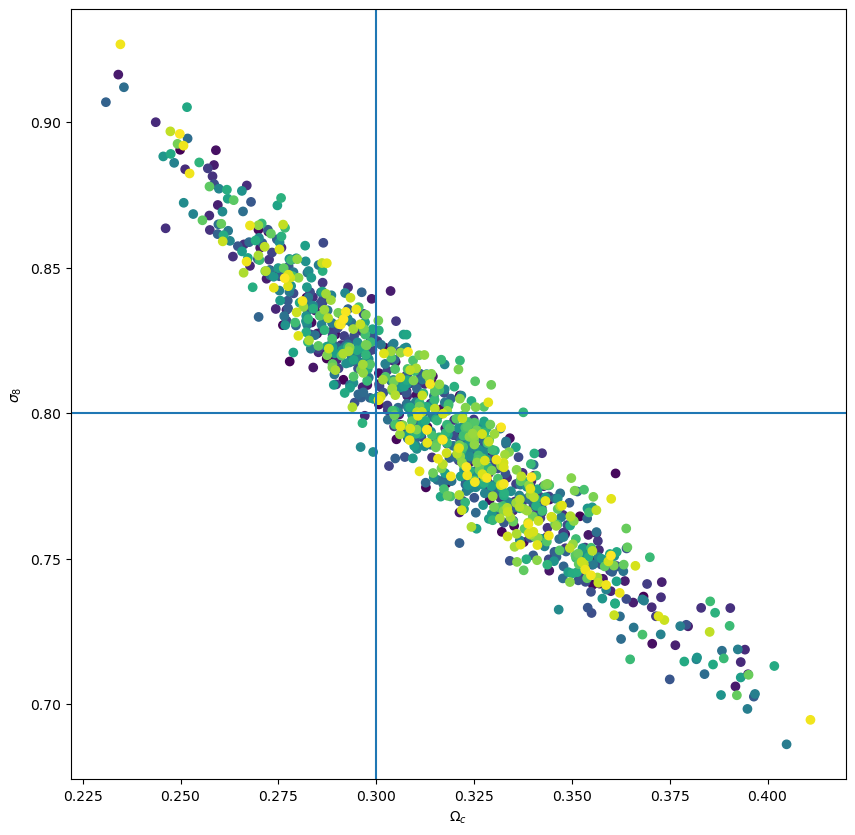

In [73]:
plt.figure(figsize=[10,10])
plt.scatter(res['omega_c']* 0.05 + 0.3, res['sigma_8']* 0.05 + 0.8, c=np.arange(len(res['sigma_8'])));
plt.axvline(0.3)
plt.axhline(0.8)
plt.xlabel(r'$\Omega_c$')
plt.ylabel(r'$\sigma_8$')

We can also plot the mean value of the latent variable, but it's not very interesting.

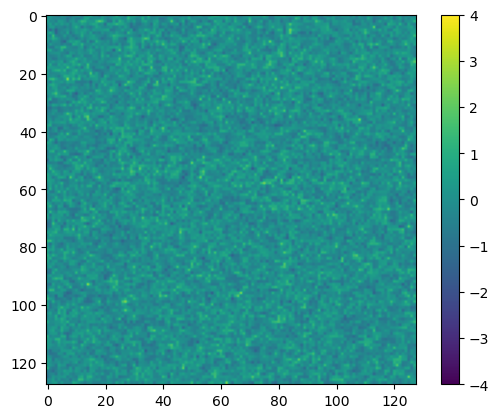

In [74]:
plt.imshow(res['z'].mean(axis=0),vmin=-4,vmax=4); 
plt.colorbar()

Let's generate a map for our (bad) pror cosmology with the MCMC samples' preferred latent variable.

In [75]:
conditional_model = condition(model, {'z': res['z'].mean(axis=0), 'omega_c': 0., 'sigma_8': 0.})

In [76]:
sample_map_rec = seed(conditional_model, jax.random.PRNGKey(2))
m_data_rec = sample_map_rec()

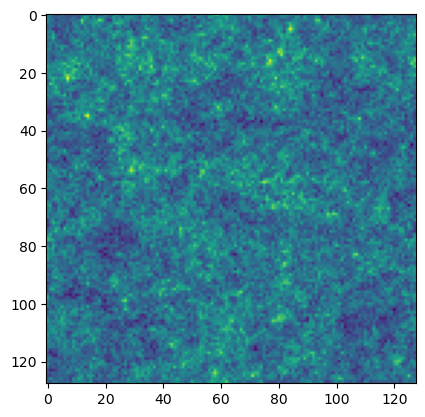

In [77]:
plt.imshow(m_data_rec)

We can then look at the lensing map predicted by the mean values of the cosmological parameters _(I think)_.
Yeah, that looks pretty reasonable!

In [78]:
model_trace = trace(sample_map_rec).get_trace()

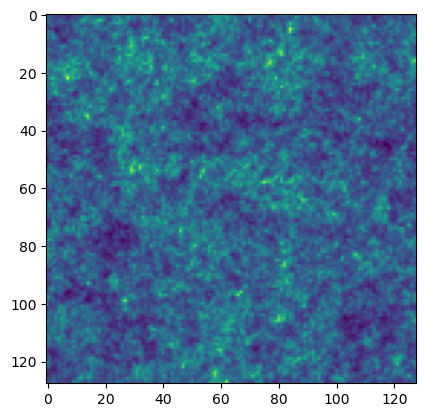

In [79]:
plt.imshow(model_trace['x']['fn'].mean)

## CHALLENGE: ABC

Write an ABC version of the above inference.
The steps are as follows:
![algorithm](m_stx894alg1.jpeg "ABC")

## Part 2: Simulation-based inference

Let's pretend we don't know how to use `numpyro` to sample the `jax` likelihood with MCMC sampling _(easy enough because it's basically magic to me)_ and instead use simulation-based inference.
Better yet, let's pretend we don't know the physics to generate weak lensing observations at all.

In [80]:
## DemoSBI

First, we need to establish an observation against which we're going to compare our predictions to constrain the cosmological parameters.

In [81]:
cosmo = jc.Planck15()                  # Create a cosmology with default parameters
nz = jc.redshift.smail_nz(1., 2,  0.75, 
                  gals_per_arcmin2=6)  # Create a Smail redshift distribution
tracer = jc.probes.WeakLensing([nz])   # Define a lensing probe

# Let's build an array of parameters 
fid_params = np.array([cosmo.Omega_c, cosmo.sigma8]) 

# An array of ells
ell = jnp.logspace(2, np.log10(2_000), 20)

# Computing the mean and covariance matrix for this cosmology and this tracer
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125);

The implicit likelihood is for the summary statistic given cosmology, so $p(C_{\ell} | \Omega_{c}, \sigma_{8})$.
This is essentially the simulator!
It doesn't even know about weak lensing mass maps.

In [82]:
# Let's define a function that will sample a Cl for a given cosmology
@jax.jit
def sample_likelihood(params, key):
    cosmo = jc.Planck15(Omega_c=params[0], sigma8=params[1])
    mu = jc.angular_cl.angular_cl(cosmo, ell, [tracer]).flatten() 
    dist = tfd.MultivariateNormalDiag(loc=mu, 
                                    scale_diag=jnp.sqrt(jnp.diag(cov)))
    return dist.sample(seed=key)

The sumamry statistic is pretty stable over random realizations of data given the same cosmological parameters.

/tmp/ipykernel_444/3259146227.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.plot(ell, mu, '--', 'fiducial cosmology')
/tmp/ipykernel_444/3259146227.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.plot(ell, mu, '--', 'fiducial cosmology')
/tmp/ipykernel_444/3259146227.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.plot(ell, mu, '--', 'fiducial cosmology')
/tmp/ipykernel_444/3259146227.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed tw

Text(0, 0.5, 'power spectrum $C_{\\ell}$')

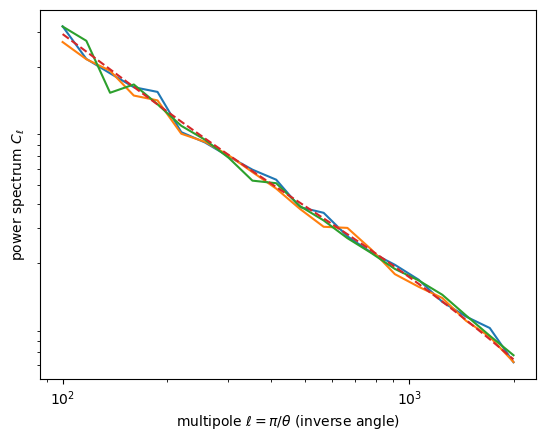

In [83]:
# Draw measured cls for different seeds at the fiducial cosmology
plt.plot(ell, sample_likelihood(fid_params, jax.random.PRNGKey(0)))
plt.plot(ell, sample_likelihood(fid_params, jax.random.PRNGKey(1)))
plt.plot(ell, sample_likelihood(fid_params, jax.random.PRNGKey(2)))
plt.loglog()

plt.plot(ell, mu, '--', 'fiducial cosmology')

plt.xlabel(r'multipole $\ell=\pi/\theta$ (inverse angle)')
plt.ylabel(r'power spectrum $C_{\ell}$')

We can use this spiffy canned `sbi` package to  perform the inference.
[Here's a tutorial showing its options](https://github.com/mackelab/sbi/blob/main/tutorials/00_getting_started.ipynb).
All we need is a `simulator` and a `prior`.
Let's use a flat prior on both cosmological parameters and the summary statistic likelihood sampler defined above.

In [84]:
num_dim = 2
prior = utils.BoxUniform(low=0.1 * torch.ones(num_dim), high=1 * torch.ones(num_dim))

def simulator(parameter_set):
    return sample_likelihood(parameter_set.cpu().detach().numpy(), next(seq)).to_py()

With these ingredients, we can define a posterior, which is a model the `sbi` package trains by a process it confusingly calls inference, by generating and then effectively interpolating over many instances of parameters drawn from the prior and observations drawn from the `simulator` and `prior` -- this is not our inference step!
Feel free to experiment with the different options for the "inference" approach (`SNPE`, `SNLE`, `SNRE`).
For our purposes, they all correspond to "LFI" and not "ABC."

In [85]:
#takes minutes on laptop
posterior = infer(simulator, prior, method="SNPE", num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 254 epochs.

Let's get down to business and make our one real observation.

In [86]:
observation = sample_likelihood(fid_params, jax.random.PRNGKey(0)).to_py()

Now we can condition on our observation and sample the trained posterior.

In [87]:
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

The samples can be treated just like MCMC samples (see Tuesday's `metrics.ipynb` notebook for more).

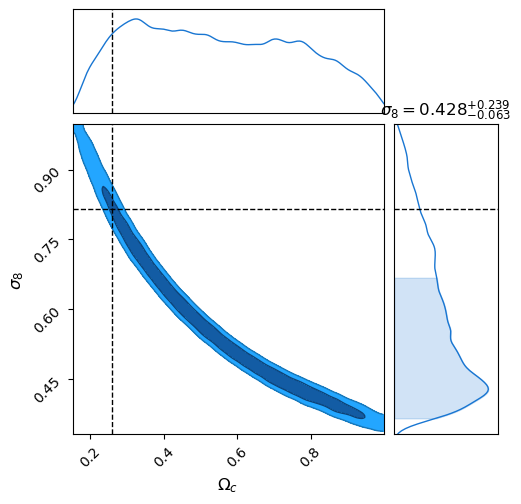

In [88]:
c = ChainConsumer()
c.add_chain(samples.cpu().detach().numpy(), parameters=["$\Omega_c$", "$\sigma_8$"], name='SBI')

fig = c.plotter.plot(figsize="column", truth=fid_params)

These look like very reasonable constraints on the cosmological parameters in that they have the right physical degeneracy -- without knowing any physics! -- but they're still quite broad.
Can you make them better?

## CHALLENGE: another prefab example of LFI (surprise, it's photo-$z$s!)

Refer back to yesterday's `expdes-photoz.ipynb` problem set.
[`pzflow`](https://github.com/jfcrenshaw/pzflow) is another example of a "simulator" for the purposes of LFI.
Instead of using it to generate mock data, use it as an estimator following the `pzflow` tutorials from its GitHub repository and experiment with model assumptions (retrain using different data sets) to see how those affect the estimated posteriors.

For the sake of expediency, pre-trained models of the $p(z, photometry)$ joint probability space are provided as `.pkl` files [here](https://github.com/aimalz/dsfp2022/tree/main/data), where the training sets are the [Happy/Teddy data sets](https://github.com/COINtoolbox/photoz_catalogues) (see [Beck, et al 2017](https://arxiv.org/abs/1701.08748) for full release notes), curated subsamples of the [Sloan Digital Sky Survey (SDSS) Data Release (DR) 12](https://www.sdss.org/dr12/),created by the [Cosmostatistics Initiative (COIN)](https://cosmostatistics-initiative.org/).
(Recall that the training set is a sort of prior on the relationship between redshift and photometry.)

In [61]:
for name in ['happy', 'teddy']:
    for lett in ['A', 'B', 'C', 'D']:     
        print(name+lett)
        flow = Flow(file=name+lett+'flow.pkl')

happyA


NameError: name 'Flow' is not defined

Use the totally unrelated data that comes with `pzflow` as a test set on which you want to estimate redshifts from photometry.

In [59]:
z_min, z_max = 0., 1.5
r_min, r_max = 10., 25.

from pzflow.examples import get_galaxy_data

data = get_galaxy_data()

# restrict to Happy/Teddy range for coverage in demo
data = data[(data['redshift'] > z_min) & (data['redshift'] < z_max) & (data['r'] > r_min) & (data['r'] < r_max)]

# normalize
data = data

# use fewer bands to be able to compare with Happy/Teddy
data = data[['redshift', 'u', 'g', 'r', 'i', 'z']]

# convert magnitudes to a reference magnitude and colors
data['u-g'] = data['u'] - data['g']
data['g-r'] = data['g'] - data['r']
data['r-i'] = data['r'] - data['i']
data['i-z'] = data['i'] - data['z']

# save the new set
data = data[['redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z']]

This is the syntax for how to estimate posteriors:

In [60]:
granularity = 100
grid = np.linspace(z_min, z_max, granularity)

chosen = 42

galaxy = data.iloc[[chosen]]
pdf = flow.posterior(galaxy, column="redshift", grid=grid)

plt.plot(grid, pdf[0], label='Posterior')
plt.axvline(galaxy['redshift'].values[0], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()

NameError: name 'flow' is not defined

Now you have everything you need to experiment with a likelihood-free way to estimate redshifts from photometry!

As a bonus, you can give `flow.posterior()` an extra keyword argument, `err_samples`, to make it extra Bayesian, if your test set data have columns named `[col]_err` for original column names `[col]`.
(You can populate these heuristically as, e.g. 1% or 10% of the original `[col]` values.)
Then you can experiment with different numbers of `err_samples`, which takes into account observation errors on the photometry.